# EDA

## Install Packages

We install: 
- Audio processing: `librosa`, `mutagen`
- Plots: `Plotly`, `matplotlib`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

     |████████████████████████████████| 218 kB 4.3 MB/s 


In [3]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

## Data Processing

In [4]:
# Unzip dataset
# !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
# !tar -xzf urban8k.tgz
# !rm urban8k.tgz
!rm -r '/content/UrbanSound8K'
!unzip '/content/drive/MyDrive/Colab Notebooks/urban/UrbanSound8K.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UrbanSound8K/audio/fold4/154758-5-0-21.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-3.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-4.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-5.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-6.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-7.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-8.wav  
  inflating: UrbanSound8K/audio/fold4/154758-5-0-9.wav  
  inflating: UrbanSound8K/audio/fold4/155320-3-0-0.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-0-0.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-0-1.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-0-2.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-0-3.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-1-0.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-2-0.wav  
  inflating: UrbanSound8K/audio/fold4/156362-4-2-1.wav  
  inflating: UrbanSound8K/audio/fold

In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

## Data Analysis

We will perform a set of data analysis steps to observe and see patterns in the data given and choose the best modeling accordingly. 

### Data Statistics
We want to see how the audio files were recorded and how the different classes are distributed.  




In [5]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [6]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                     filepath  
0          dog_bark    UrbanSound8K/audio/fold5/100032-3-0-0.wav  
1  children_playing  UrbanSound8K/audio/fold5/100263-2-0-117.wav  
2  children_playing  UrbanSound8K/audio/fold5/100263-2-0-121.wav  
3  children_playing  UrbanSound8K/audio/fold5/100263-2-0-126.wav  
4  children_playing  UrbanSound8K/audio/fold5/100263-2-0-137.wav

In [ ]:
cls_cnt = dataset_df.groupby('class').slice_file_name.count()
cls_cnt

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

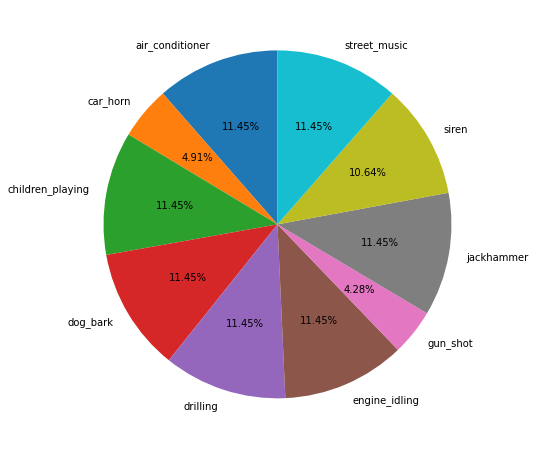

In [ ]:
plt.figure(figsize=(8,8))

plt.pie(cls_cnt,
        labels=cls_cnt.index,
        startangle=90,
        autopct='%1.2f%%')

plt.show()

We can observe all the classes except `car_horn`, `gun_shot` and `siren` have 1000 samples. We could explore options to include **class weights** in the loss function or **oversampling** if we see that the under-represented classes are not being classified as well as the rest.  

Next we compute the audio files statistics...

In [7]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata 
    

def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []} 
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]
    
    return dataset_df

In [8]:
dataset_df = dataset_df.drop(columns=['slice_file_name', 'fsID', 'start', 'end'])

In [9]:
dataset_df.head(20)

salience  fold  classID             class  \
0          1     5        3          dog_bark   
1          1     5        2  children_playing   
2          1     5        2  children_playing   
3          1     5        2  children_playing   
4          1     5        2  children_playing   
5          1     5        2  children_playing   
6          1     5        2  children_playing   
7          1     5        2  children_playing   
8          1     5        2  children_playing   
9          2    10        1          car_horn   
10         2    10        1          car_horn   
11         2    10        1          car_horn   
12         2    10        1          car_horn   
13         2    10        1          car_horn   
14         1     2        3          dog_bark   
15         1     2        3          dog_bark   
16         1     2        3          dog_bark   
17         1     2        3          dog_bark   
18         1    10        3          dog_bark   
19         1    10        3          dog_bark   

                                       filepath  
0     UrbanSound8K/audio/fold5/100032-3-0-0.wav  
1   UrbanSound8K/audio/fold5/100263-2-0-117.wav  
2   UrbanSound8K/audio/fold5/100263-2-0-121.wav  
3   UrbanSound8K/audio/fold5/100263-2-0-126.wav  
4   UrbanSound8K/audio/fold5/100263-2-0-137.wav  
5   UrbanSound8K/audio/fold5/100263-2-0-143.wav  
6   UrbanSound8K/audio/fold5/100263-2-0-161.wav  
7     UrbanSound8K/audio/fold5/100263-2-0-3.wav  
8    UrbanSound8K/audio/fold5/100263-2-0-36.wav  
9    UrbanSound8K/audio/fold10/100648-1-0-0.wav  
10   UrbanSound8K/audio/fold10/100648-1-1-0.wav  
11   UrbanSound8K/audio/fold10/100648-1-2-0.wav  
12   UrbanSound8K/audio/fold10/100648-1-3-0.wav  
13   UrbanSound8K/audio/fold10/100648-1-4-0.wav  
14    UrbanSound8K/audio/fold2/100652-3-0-0.wav  
15    UrbanSound8K/audio/fold2/100652-3-0-1.wav  
16    UrbanSound8K/audio/fold2/100652-3-0-2.wav  
17    UrbanSound8K/audio/fold2/100652-3-0-3.wav  
18   UrbanSound8K/audio/fold10/100795-3-0-0.wav  
19   UrbanSound8K/audio/fold10/100795-3-1-0.wav

In [10]:
dataset_df = compute_audio_statistics(dataset_df)

In [ ]:
dataset_df.head()

salience  fold  classID             class  \
0         1     5        3          dog_bark   
1         1     5        2  children_playing   
2         1     5        2  children_playing   
3         1     5        2  children_playing   
4         1     5        2  children_playing   

                                      filepath    length  bitrate  channels  \
0    UrbanSound8K/audio/fold5/100032-3-0-0.wav  0.317551   352800         2   
1  UrbanSound8K/audio/fold5/100263-2-0-117.wav  4.000000   352800         2   
2  UrbanSound8K/audio/fold5/100263-2-0-121.wav  4.000000   352800         2   
3  UrbanSound8K/audio/fold5/100263-2-0-126.wav  4.000000   352800         2   
4  UrbanSound8K/audio/fold5/100263-2-0-137.wav  4.000000   352800         2   

   sample_rate  bits_per_sample  
0        44100               16  
1        44100               16  
2        44100               16  
3        44100               16  
4        44100               16

We can observe in the following tables that the data has been recorded and digitalized in different ways. 

- It has been mostly recorded using 2 channels in almost all the samples (stereo). 
- The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
- The length of the audios goes from 0.0008s to 4s (mostly 4s)
- The bits per sample used go from 4 to 32 (mostly 24 bits)

The data will need to be standardized before to be fed to a machine learning model. 

In [ ]:
dataset_df.describe()

salience         fold      classID       length       bitrate  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8.732000e+03   
mean      1.347000     5.385937     4.592877     3.603644  4.495311e+05   
std       0.476043     2.846820     2.894544     0.980913  5.480813e+05   
min       1.000000     1.000000     0.000000     0.000816  1.102500e+04   
25%       1.000000     3.000000     2.000000     4.000000  3.528000e+05   
50%       1.000000     5.000000     4.000000     4.000000  3.528000e+05   
75%       2.000000     8.000000     7.000000     4.000000  5.292000e+05   
max       2.000000    10.000000     9.000000     4.000000  4.515840e+07   

          channels    sample_rate  bits_per_sample  
count  8732.000000    8732.000000      8732.000000  
mean      1.915369   48456.979272        18.780119  
std       0.278348   15300.080707         4.227168  
min       1.000000    8000.000000         4.000000  
25%       2.000000   44100.000000        16.000000  
50%       2.000000   44100.000000        16.000000  
75%       2.000000   48000.000000        24.000000  
max       2.000000  192000.000000        32.000000

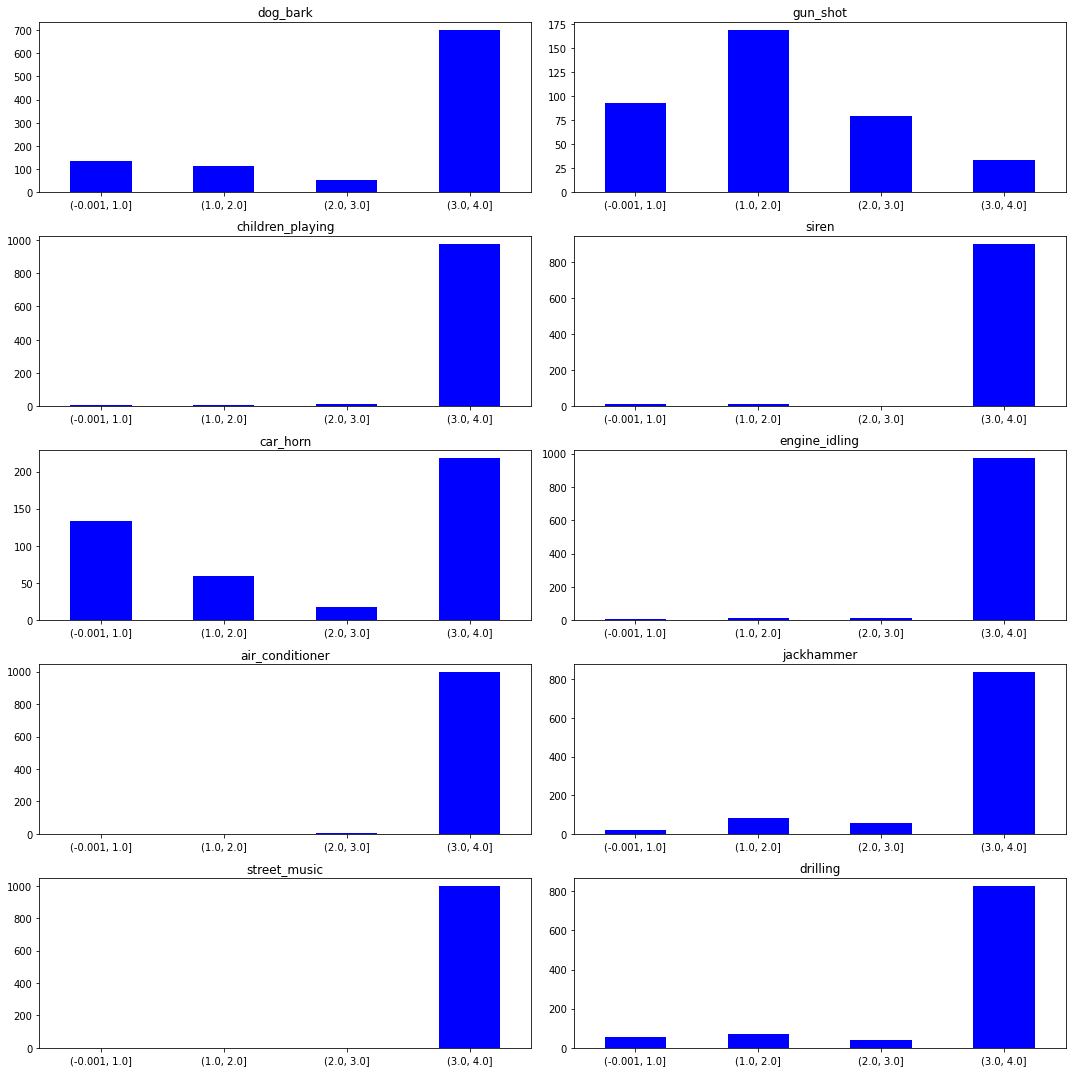

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
labels = dataset_df['class'].unique()
for col in range(2):
    for row in range(5):
        out = pd.cut(dataset_df['length'].where(dataset_df['class'] == labels[index]), bins=[0,1,2,3,4], include_lowest=True)
        out.value_counts(sort=False).plot.bar(rot=0, color="b",ax=axs[row][col] )
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


In [12]:
dataset_df['sample_rate'].value_counts(), dataset_df['bits_per_sample'].value_counts()

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64, 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64)

### Data Visualization
As the data consists of Audio files we will use the `Librosa` library to load, plot and perform audio processing. 

We will use the `IPython.display.Audio` package to listen the files directly in the Jupyter Notebook/ google colab. 

### Waveform

First we can visualize the waveform for different random samples of each class:

In [13]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
random_samples

salience  fold  classID             class  \
7805         2     8        0   air_conditioner   
6144         1     7        1          car_horn   
3626         1     9        2  children_playing   
65           1     1        3          dog_bark   
1766         1     4        4          drilling   
2065         1     7        5     engine_idling   
1807         2     2        6          gun_shot   
2019         2     4        7        jackhammer   
5809         2     4        8             siren   
578          1     6        9      street_music   

                                        filepath    length  bitrate  channels  \
7805   UrbanSound8K/audio/fold8/74677-0-0-92.wav  4.000000   352800         2   
6144    UrbanSound8K/audio/fold7/34241-1-2-0.wav  3.745941   529200         2   
3626  UrbanSound8K/audio/fold9/174786-2-0-39.wav  4.000000   576000         2   
65     UrbanSound8K/audio/fold1/101415-3-0-3.wav  4.000000    96000         1   
1766   UrbanSound8K/audio/fold4/144351-4-3-4.wav  4.000000   288000         1   
2065   UrbanSound8K/audio/fold7/149193-5-0-0.wav  4.000000  1152000         2   
1807   UrbanSound8K/audio/fold2/145608-6-3-0.wav  0.907188   768000         2   
2019   UrbanSound8K/audio/fold4/148463-7-3-8.wav  4.000000   144000         1   
5809    UrbanSound8K/audio/fold4/24347-8-0-6.wav  4.000000   384000         2   
578    UrbanSound8K/audio/fold6/108638-9-0-1.wav  4.000000   352800         2   

      sample_rate  bits_per_sample  
7805        44100               16  
6144        44100               24  
3626        48000               24  
65          48000               16  
1766        96000               24  
2065        96000               24  
1807        96000               16  
2019        48000               24  
5809        48000               16  
578         44100               16

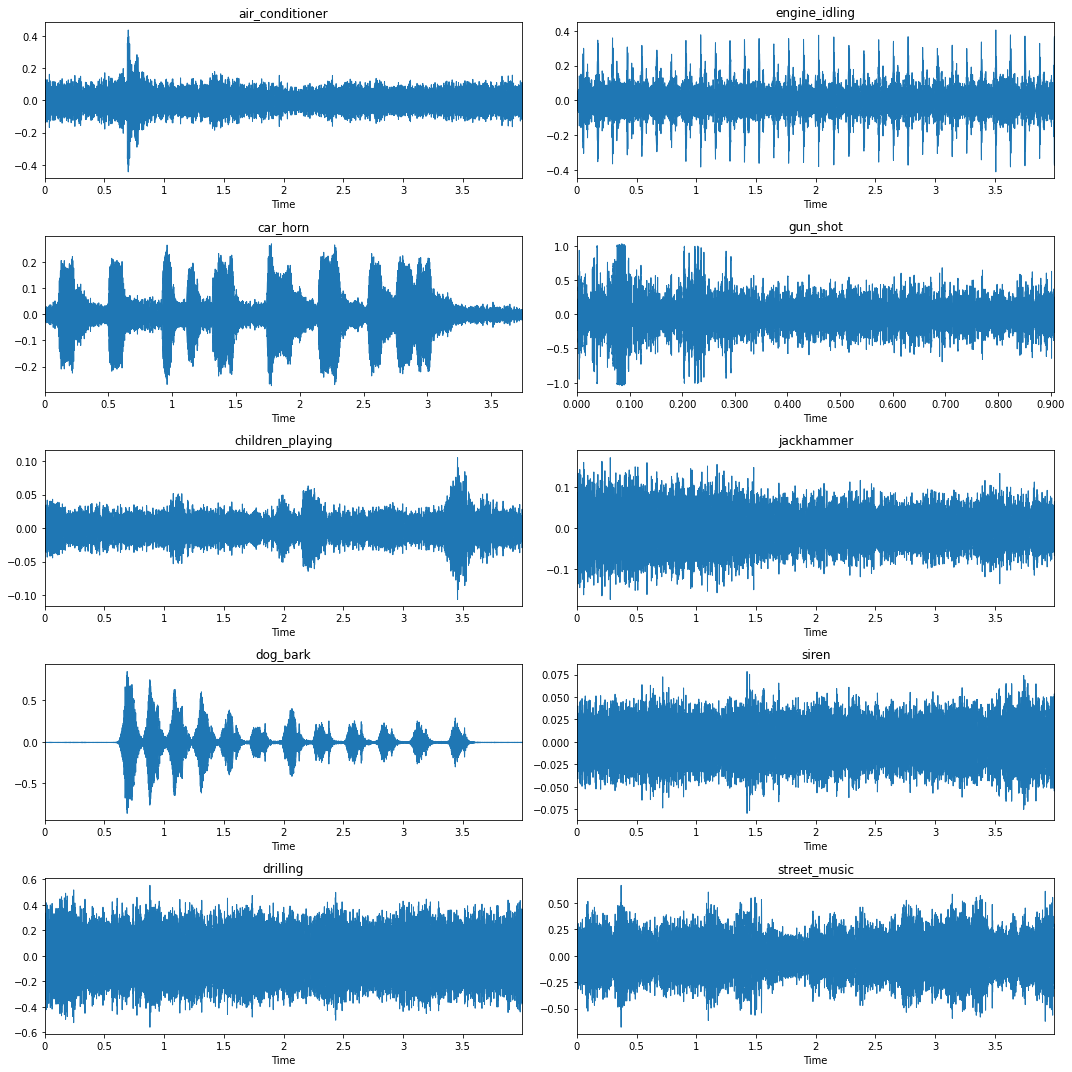

In [14]:

audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveplot(audio_file, sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks. 

### STFT (Log Y Axis)

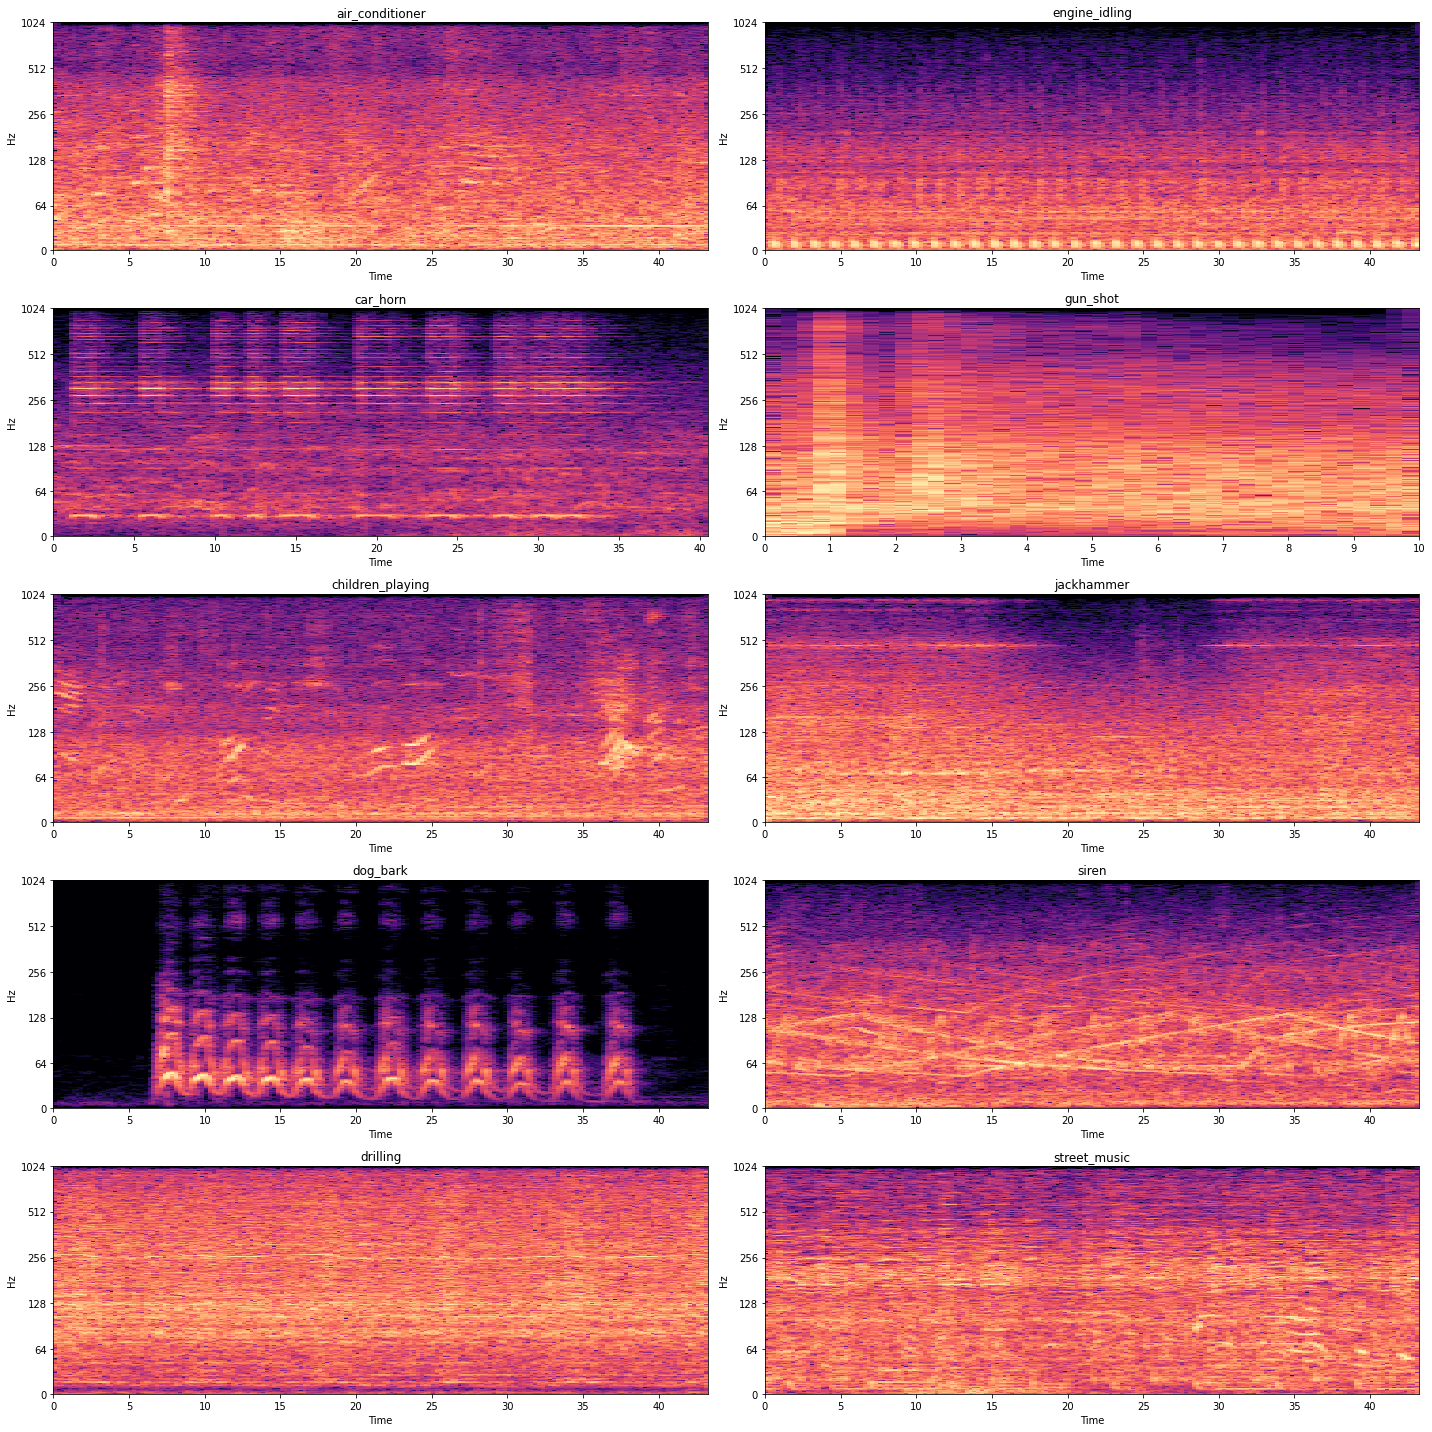

In [15]:
# Visualize the STFT
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft, hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

### Mel-Spectogram

Next we will visualize the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.


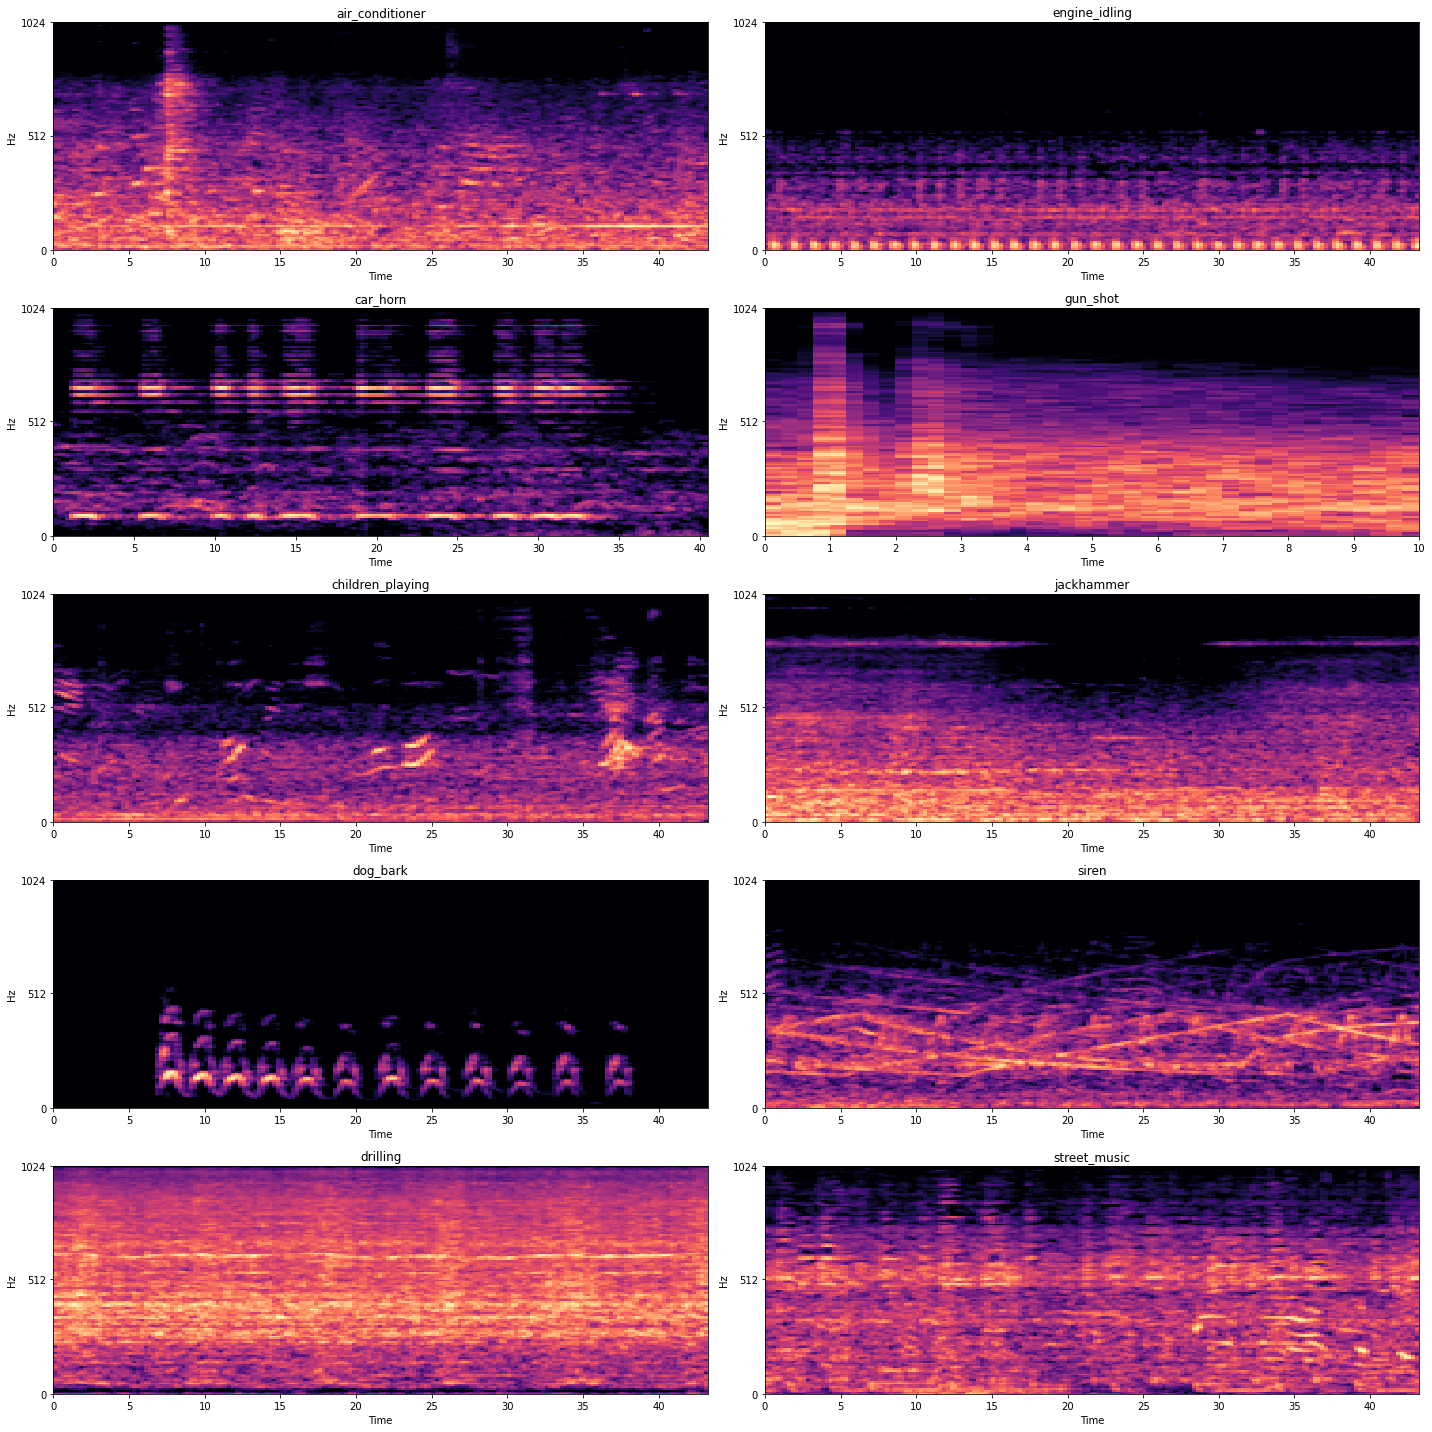

In [17]:
# Visualize the Mel-Spectograms
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mel = librosa.feature.melspectrogram(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # Mel-Spectogram of y
        S_db = librosa.amplitude_to_db(np.abs(mel), ref=np.max)
        librosa.display.specshow(S_db, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


In [18]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 0
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to air_conditioner sample


In [19]:
audio_file, sample_rate = librosa.load(audio_samples[0])
stft = librosa.stft(audio_file)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)
S_db

(1025, 173)


array([[-15.650674, -20.811855, -54.724804, ..., -44.33052 , -39.876686,
        -25.751188],
       [-17.844849, -21.941353, -32.186687, ..., -42.461502, -34.893867,
        -23.43229 ],
       [-17.255291, -28.317863, -24.577654, ..., -33.454105, -25.426514,
        -21.347748],
       ...,
       [-57.616318, -63.646526, -80.      , ..., -80.      , -80.      ,
        -75.89525 ],
       [-57.663586, -63.68173 , -80.      , ..., -80.      , -80.      ,
        -75.79316 ],
       [-57.68287 , -63.72487 , -80.      , ..., -80.      , -80.      ,
        -75.43008 ]], dtype=float32)

### MFCCs

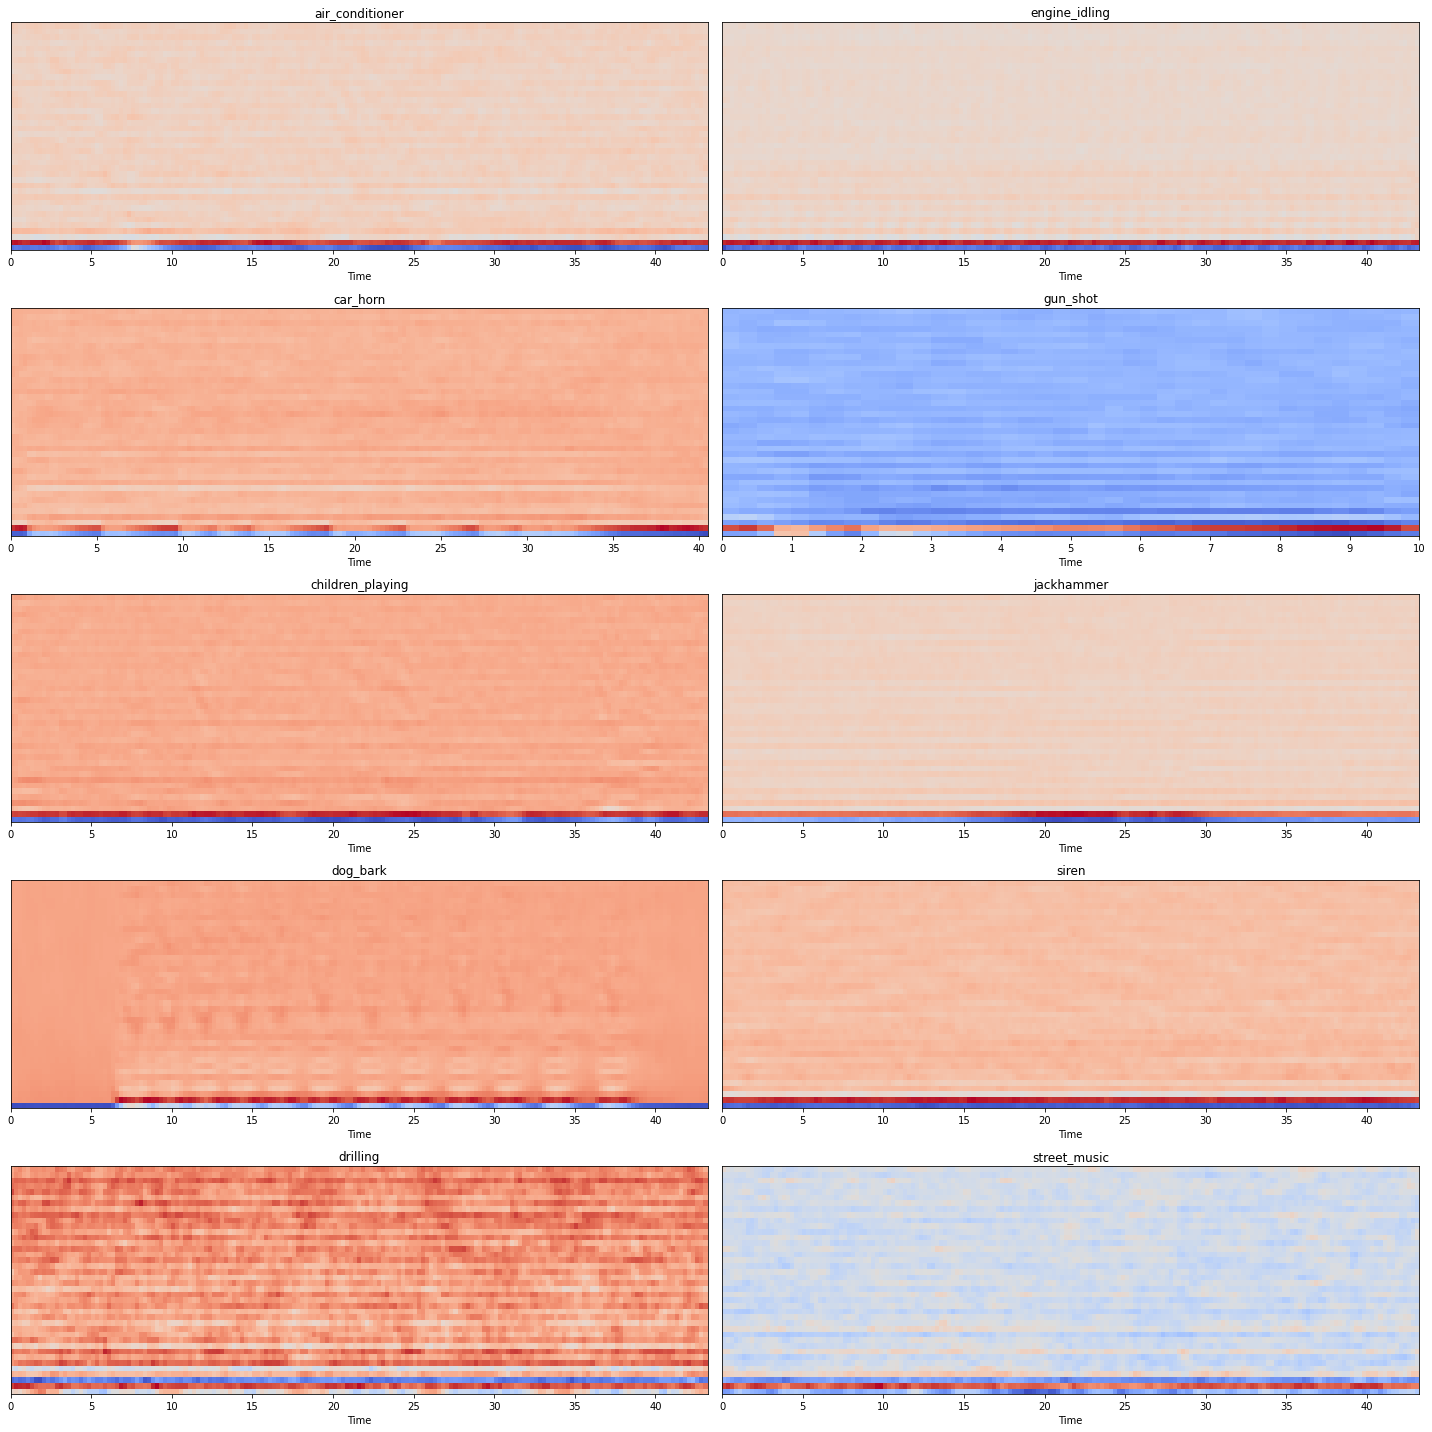

In [20]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=40)
        librosa.display.specshow(mfccs, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


After taking a look at the graphs for some different permutations, we can observe that the signals for the dataset classes are different enough to be classified correctly. 

We will use a machine learning algorithm to process this data and classify the different audio files. 

In [ ]:

dataset_df.head()

salience  fold  classID             class  \
0         1     5        3          dog_bark   
1         1     5        2  children_playing   
2         1     5        2  children_playing   
3         1     5        2  children_playing   
4         1     5        2  children_playing   

                                      filepath    length  bitrate  channels  \
0    UrbanSound8K/audio/fold5/100032-3-0-0.wav  0.317551   352800         2   
1  UrbanSound8K/audio/fold5/100263-2-0-117.wav  4.000000   352800         2   
2  UrbanSound8K/audio/fold5/100263-2-0-121.wav  4.000000   352800         2   
3  UrbanSound8K/audio/fold5/100263-2-0-126.wav  4.000000   352800         2   
4  UrbanSound8K/audio/fold5/100263-2-0-137.wav  4.000000   352800         2   

   sample_rate  bits_per_sample  
0        44100               16  
1        44100               16  
2        44100               16  
3        44100               16  
4        44100               16

In [ ]:
#preprocessing using entire feature set
from tqdm import tqdm

# x_train=[]
# x_test=[]
# y_train=[]
# y_test=[]
X=[]
Y=[]

for i,row in tqdm(dataset_df.iterrows()):
  fold_no=str(dataset_df.iloc[i]["fold"])
  filename = str(row["filepath"])
  label=row["class"]

  y,sr=librosa.load(filename)

  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
  melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
  chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
  chroma_cq = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=40,bins_per_octave=40).T,axis=0)
  chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=40,bins_per_octave=40).T,axis=0)

  features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))
  X.append(features)
  Y.append(label)


  # if(fold_no!='10'):
  #   x_train.append(features)
  #   y_train.append(label)
  # else:
  #   x_test.append(features)
  #   y_test.append(label)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=876
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=438
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=219
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=110
  n_fft, y.shape[-1]
9it [00:05,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=894
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=447
  n_fft, y.shape[-1]
/usr/local/l

In [ ]:
type(Y)

list

In [ ]:
dataset_df.shape

(8732, 10)

In [ ]:
#converting the lists into numpy arrays
X = np.array(X)
y = np.array(Y)
X.shape,y.shape

((8732, 40, 5), (8732,))

In [ ]:
# #reshaping into 2d to save in csv format
x_2d=np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))
x_2d.shape

(8732, 200)

In [ ]:
type(y)
# y

numpy.ndarray

In [ ]:
# #saving the data numpy arrays

np.savetxt("X.csv",x_2d,delimiter=",", fmt='%s')
np.savetxt("y.csv",y,delimiter=",", fmt='%s')

In [ ]:
# # downloading the saved data from colab's server
from google.colab import files

files.download("X.csv")
files.download("y.csv")

In [ ]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
import pandas as pd

X = genfromtxt('datainCSV/X.csv', delimiter=',')
y = pd.read_csv('datainCSV/y.csv',)

In [ ]:
X.shape,y.shape

((8732, 200), (8732, 1))

In [ ]:
y

classes
0             dog_bark
1     children_playing
2     children_playing
3     children_playing
4     children_playing
...                ...
8727          car_horn
8728          car_horn
8729          car_horn
8730          car_horn
8731          car_horn

[8732 rows x 1 columns]

In [ ]:
Y = []
for i in y['classes']:
  Y.append(i)

In [ ]:
import numpy as np

y = np.array(Y)
y.shape

(8732,)

In [ ]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y),num_classes=10)
y


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
labelencoder.classes_

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype='<U16')

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

In [ ]:
#shape
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((7858, 200), (874, 200), (7858, 10), (874, 10))

In [ ]:
#reshaping to 2D 
x_train=np.reshape(x_train,(x_train.shape[0], 40,5))
x_test=np.reshape(x_test,(x_test.shape[0], 40,5))
x_train.shape,x_test.shape

((7858, 40, 5), (874, 40, 5))

In [ ]:
#reshaping to shape required by CNN
x_train=np.reshape(x_train,(x_train.shape[0], 40,5,1))
x_test=np.reshape(x_test,(x_test.shape[0], 40,5,1))

In [ ]:
#shapes
x_train.shape,x_test.shape

((7858, 40, 5, 1), (874, 40, 5, 1))

In [ ]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(40,5,1)))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))


# #forming model
# model=Sequential()

# #adding layers and forming the model
# model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,5,1)))
# model.add(MaxPooling2D(padding="same"))

# model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
# model.add(MaxPooling2D(padding="same"))
# model.add(Dropout(0.3))

# model.add(Flatten())

# model.add(Dense(256,activation="relu"))
# model.add(Dropout(0.3))

# model.add(Dense(512,activation="relu"))
# model.add(Dropout(0.3))

# model.add(Dense(10,activation="softmax"))


In [ ]:
#compiling

opt = Adam(learning_rate=0.00001)

model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1000
num_batch_size = 1024

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 2.5453 - accuracy: 0.1145
Epoch 00001: val_loss improved from inf to 2.31102, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 11s 1s/step - loss: 2.5453 - accuracy: 0.1145 - val_loss: 2.3110 - val_accuracy: 0.1030
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 2.4460 - accuracy: 0.1242
Epoch 00002: val_loss improved from 2.31102 to 2.25291, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 2.4460 - accuracy: 0.1242 - val_loss: 2.2529 - val_accuracy: 0.1270
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 2.3823 - accuracy: 0.1301
Epoch 00003: val_loss improved from 2.25291 to 2.21913, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 2.3823 - accuracy: 0.1301 - val_loss: 2.2191 - val_accuracy: 0.1842
Epoch 4/10

Epoch 26/1000
8/8 [==============================] - ETA: 0s - loss: 1.9614 - accuracy: 0.3208
Epoch 00026: val_loss improved from 1.87074 to 1.85231, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.9614 - accuracy: 0.3208 - val_loss: 1.8523 - val_accuracy: 0.4268
Epoch 27/1000
8/8 [==============================] - ETA: 0s - loss: 1.9526 - accuracy: 0.3288
Epoch 00027: val_loss improved from 1.85231 to 1.83310, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.9526 - accuracy: 0.3288 - val_loss: 1.8331 - val_accuracy: 0.4336
Epoch 28/1000
8/8 [==============================] - ETA: 0s - loss: 1.9397 - accuracy: 0.3288
Epoch 00028: val_loss improved from 1.83310 to 1.81493, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.9397 - accuracy: 0.3288 - val_loss: 1.8149 - val_accuracy: 0.4405
Epoc

Epoch 51/1000
8/8 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.4504
Epoch 00051: val_loss improved from 1.46996 to 1.45711, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.6163 - accuracy: 0.4504 - val_loss: 1.4571 - val_accuracy: 0.5309
Epoch 52/1000
8/8 [==============================] - ETA: 0s - loss: 1.5949 - accuracy: 0.4548
Epoch 00052: val_loss improved from 1.45711 to 1.44659, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.5949 - accuracy: 0.4548 - val_loss: 1.4466 - val_accuracy: 0.5297
Epoch 53/1000
8/8 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.4641
Epoch 00053: val_loss improved from 1.44659 to 1.43495, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.5873 - accuracy: 0.4641 - val_loss: 1.4350 - val_accuracy: 0.5332
Epoc

Epoch 76/1000
8/8 [==============================] - ETA: 0s - loss: 1.3641 - accuracy: 0.5341
Epoch 00076: val_loss improved from 1.24820 to 1.24051, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.3641 - accuracy: 0.5341 - val_loss: 1.2405 - val_accuracy: 0.6030
Epoch 77/1000
8/8 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.5377
Epoch 00077: val_loss improved from 1.24051 to 1.23358, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.3612 - accuracy: 0.5377 - val_loss: 1.2336 - val_accuracy: 0.6007
Epoch 78/1000
8/8 [==============================] - ETA: 0s - loss: 1.3537 - accuracy: 0.5405
Epoch 00078: val_loss improved from 1.23358 to 1.22540, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.3537 - accuracy: 0.5405 - val_loss: 1.2254 - val_accuracy: 0.6041
Epoc

Epoch 101/1000
8/8 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.5897
Epoch 00101: val_loss improved from 1.10213 to 1.09660, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.2082 - accuracy: 0.5897 - val_loss: 1.0966 - val_accuracy: 0.6533
Epoch 102/1000
8/8 [==============================] - ETA: 0s - loss: 1.1951 - accuracy: 0.5925
Epoch 00102: val_loss improved from 1.09660 to 1.09267, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.1951 - accuracy: 0.5925 - val_loss: 1.0927 - val_accuracy: 0.6545
Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.5940
Epoch 00103: val_loss improved from 1.09267 to 1.08649, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.2036 - accuracy: 0.5940 - val_loss: 1.0865 - val_accuracy: 0.6545
E

Epoch 126/1000
8/8 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.6343
Epoch 00126: val_loss improved from 0.99186 to 0.98711, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.0864 - accuracy: 0.6343 - val_loss: 0.9871 - val_accuracy: 0.6831
Epoch 127/1000
8/8 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.6330
Epoch 00127: val_loss improved from 0.98711 to 0.98353, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.0871 - accuracy: 0.6330 - val_loss: 0.9835 - val_accuracy: 0.6842
Epoch 128/1000
8/8 [==============================] - ETA: 0s - loss: 1.0758 - accuracy: 0.6357
Epoch 00128: val_loss improved from 0.98353 to 0.98072, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 1.0758 - accuracy: 0.6357 - val_loss: 0.9807 - val_accuracy: 0.6854
E

Epoch 151/1000
8/8 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.6754
Epoch 00151: val_loss improved from 0.90043 to 0.89628, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.9669 - accuracy: 0.6754 - val_loss: 0.8963 - val_accuracy: 0.7128
Epoch 152/1000
8/8 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6727
Epoch 00152: val_loss improved from 0.89628 to 0.89167, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.9828 - accuracy: 0.6727 - val_loss: 0.8917 - val_accuracy: 0.7117
Epoch 153/1000
8/8 [==============================] - ETA: 0s - loss: 0.9693 - accuracy: 0.6742
Epoch 00153: val_loss improved from 0.89167 to 0.88889, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.9693 - accuracy: 0.6742 - val_loss: 0.8889 - val_accuracy: 0.7105
E

Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.7049
Epoch 00176: val_loss improved from 0.81907 to 0.81381, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8920 - accuracy: 0.7049 - val_loss: 0.8138 - val_accuracy: 0.7368
Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 0.8963 - accuracy: 0.7026
Epoch 00177: val_loss improved from 0.81381 to 0.81380, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8963 - accuracy: 0.7026 - val_loss: 0.8138 - val_accuracy: 0.7368
Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 0.8898 - accuracy: 0.7018
Epoch 00178: val_loss improved from 0.81380 to 0.80910, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8898 - accuracy: 0.7018 - val_loss: 0.8091 - val_accuracy: 0.7380
E

Epoch 201/1000
8/8 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.7385
Epoch 00201: val_loss improved from 0.74831 to 0.74350, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8096 - accuracy: 0.7385 - val_loss: 0.7435 - val_accuracy: 0.7609
Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 0.8168 - accuracy: 0.7282
Epoch 00202: val_loss improved from 0.74350 to 0.74038, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8168 - accuracy: 0.7282 - val_loss: 0.7404 - val_accuracy: 0.7632
Epoch 203/1000
8/8 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.7305
Epoch 00203: val_loss improved from 0.74038 to 0.73702, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.8124 - accuracy: 0.7305 - val_loss: 0.7370 - val_accuracy: 0.7609
E

Epoch 226/1000
8/8 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.7522
Epoch 00226: val_loss improved from 0.68581 to 0.68436, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.7429 - accuracy: 0.7522 - val_loss: 0.6844 - val_accuracy: 0.7860
Epoch 227/1000
8/8 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.7553
Epoch 00227: val_loss improved from 0.68436 to 0.67965, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.7455 - accuracy: 0.7553 - val_loss: 0.6796 - val_accuracy: 0.7860
Epoch 228/1000
8/8 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.7591
Epoch 00228: val_loss improved from 0.67965 to 0.67918, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.7386 - accuracy: 0.7591 - val_loss: 0.6792 - val_accuracy: 0.7860
E

Epoch 251/1000
8/8 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.7767
Epoch 00251: val_loss improved from 0.63166 to 0.62833, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.6768 - accuracy: 0.7767 - val_loss: 0.6283 - val_accuracy: 0.7963
Epoch 252/1000
8/8 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.7812
Epoch 00252: val_loss improved from 0.62833 to 0.62793, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.6816 - accuracy: 0.7812 - val_loss: 0.6279 - val_accuracy: 0.7963
Epoch 253/1000
8/8 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7793
Epoch 00253: val_loss improved from 0.62793 to 0.62785, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.6764 - accuracy: 0.7793 - val_loss: 0.6279 - val_accuracy: 0.7963
E

8/8 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.8148
Epoch 00301: val_loss improved from 0.54786 to 0.54497, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.5803 - accuracy: 0.8148 - val_loss: 0.5450 - val_accuracy: 0.8272
Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.8118
Epoch 00302: val_loss improved from 0.54497 to 0.54399, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.5871 - accuracy: 0.8118 - val_loss: 0.5440 - val_accuracy: 0.8261
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.8194
Epoch 00303: val_loss did not improve from 0.54399
8/8 [==============================] - 9s 1s/step - loss: 0.5729 - accuracy: 0.8194 - val_loss: 0.5444 - val_accuracy: 0.8249
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss: 0.5707

Epoch 327/1000
8/8 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.8260
Epoch 00327: val_loss improved from 0.51217 to 0.51124, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.5406 - accuracy: 0.8260 - val_loss: 0.5112 - val_accuracy: 0.8375
Epoch 328/1000
8/8 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.8313
Epoch 00328: val_loss improved from 0.51124 to 0.50918, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.5332 - accuracy: 0.8313 - val_loss: 0.5092 - val_accuracy: 0.8398
Epoch 329/1000
8/8 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8299
Epoch 00329: val_loss improved from 0.50918 to 0.50862, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.5303 - accuracy: 0.8299 - val_loss: 0.5086 - val_accuracy: 0.8375
E

Epoch 352/1000
8/8 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.8426
Epoch 00352: val_loss did not improve from 0.47805
8/8 [==============================] - 9s 1s/step - loss: 0.4965 - accuracy: 0.8426 - val_loss: 0.4789 - val_accuracy: 0.8455
Epoch 353/1000
8/8 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.8380
Epoch 00353: val_loss improved from 0.47805 to 0.47520, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.4927 - accuracy: 0.8380 - val_loss: 0.4752 - val_accuracy: 0.8478
Epoch 354/1000
8/8 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8402
Epoch 00354: val_loss did not improve from 0.47520
8/8 [==============================] - 8s 1s/step - loss: 0.4924 - accuracy: 0.8402 - val_loss: 0.4765 - val_accuracy: 0.8444
Epoch 355/1000
8/8 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8427
Epoch 00355: val_loss did

Epoch 378/1000
8/8 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.8533
Epoch 00378: val_loss did not improve from 0.44669
8/8 [==============================] - 9s 1s/step - loss: 0.4648 - accuracy: 0.8533 - val_loss: 0.4478 - val_accuracy: 0.8535
Epoch 379/1000
8/8 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.8502
Epoch 00379: val_loss improved from 0.44669 to 0.44330, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.4606 - accuracy: 0.8502 - val_loss: 0.4433 - val_accuracy: 0.8581
Epoch 380/1000
8/8 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.8516
Epoch 00380: val_loss did not improve from 0.44330
8/8 [==============================] - 8s 1s/step - loss: 0.4590 - accuracy: 0.8516 - val_loss: 0.4437 - val_accuracy: 0.8604
Epoch 381/1000
8/8 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.8506
Epoch 00381: val_loss did

Epoch 431/1000
8/8 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8713
Epoch 00431: val_loss improved from 0.39799 to 0.39726, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.4072 - accuracy: 0.8713 - val_loss: 0.3973 - val_accuracy: 0.8730
Epoch 432/1000
8/8 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8699
Epoch 00432: val_loss improved from 0.39726 to 0.39663, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.4108 - accuracy: 0.8699 - val_loss: 0.3966 - val_accuracy: 0.8741
Epoch 433/1000
8/8 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8694
Epoch 00433: val_loss improved from 0.39663 to 0.39653, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3996 - accuracy: 0.8694 - val_loss: 0.3965 - val_accuracy: 0.8730
E

Epoch 458/1000
8/8 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8777
Epoch 00458: val_loss improved from 0.37719 to 0.37686, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3793 - accuracy: 0.8777 - val_loss: 0.3769 - val_accuracy: 0.8833
Epoch 459/1000
8/8 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8787
Epoch 00459: val_loss did not improve from 0.37686
8/8 [==============================] - 9s 1s/step - loss: 0.3758 - accuracy: 0.8787 - val_loss: 0.3770 - val_accuracy: 0.8822
Epoch 460/1000
8/8 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.8830
Epoch 00460: val_loss improved from 0.37686 to 0.37578, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3689 - accuracy: 0.8830 - val_loss: 0.3758 - val_accuracy: 0.8822
Epoch 461/1000
8/8 [==============================] - ETA: 0s

Epoch 484/1000
8/8 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8844
Epoch 00484: val_loss improved from 0.35511 to 0.35460, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3570 - accuracy: 0.8844 - val_loss: 0.3546 - val_accuracy: 0.8856
Epoch 485/1000
8/8 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8898
Epoch 00485: val_loss did not improve from 0.35460
8/8 [==============================] - 9s 1s/step - loss: 0.3482 - accuracy: 0.8898 - val_loss: 0.3546 - val_accuracy: 0.8879
Epoch 486/1000
8/8 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8897
Epoch 00486: val_loss improved from 0.35460 to 0.35425, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3485 - accuracy: 0.8897 - val_loss: 0.3542 - val_accuracy: 0.8879
Epoch 487/1000
8/8 [==============================] - ETA: 0s

Epoch 538/1000
8/8 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.9007
Epoch 00538: val_loss improved from 0.32474 to 0.32285, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3091 - accuracy: 0.9007 - val_loss: 0.3229 - val_accuracy: 0.8970
Epoch 539/1000
8/8 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9067
Epoch 00539: val_loss did not improve from 0.32285
8/8 [==============================] - 9s 1s/step - loss: 0.3000 - accuracy: 0.9067 - val_loss: 0.3229 - val_accuracy: 0.8959
Epoch 540/1000
8/8 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.9006
Epoch 00540: val_loss improved from 0.32285 to 0.32239, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.3092 - accuracy: 0.9006 - val_loss: 0.3224 - val_accuracy: 0.8959
Epoch 541/1000
8/8 [==============================] - ETA: 0s

Epoch 565/1000
8/8 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.9095
Epoch 00565: val_loss did not improve from 0.31097
8/8 [==============================] - 9s 1s/step - loss: 0.2875 - accuracy: 0.9095 - val_loss: 0.3115 - val_accuracy: 0.9005
Epoch 566/1000
8/8 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9099
Epoch 00566: val_loss improved from 0.31097 to 0.31039, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.2796 - accuracy: 0.9099 - val_loss: 0.3104 - val_accuracy: 0.9005
Epoch 567/1000
8/8 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.9112
Epoch 00567: val_loss did not improve from 0.31039
8/8 [==============================] - 9s 1s/step - loss: 0.2838 - accuracy: 0.9112 - val_loss: 0.3108 - val_accuracy: 0.9027
Epoch 568/1000
8/8 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.9093
Epoch 00568: val_loss did

Epoch 592/1000
8/8 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9146
Epoch 00592: val_loss did not improve from 0.29787
8/8 [==============================] - 9s 1s/step - loss: 0.2695 - accuracy: 0.9146 - val_loss: 0.2983 - val_accuracy: 0.9039
Epoch 593/1000
8/8 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9161
Epoch 00593: val_loss improved from 0.29787 to 0.29674, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.2679 - accuracy: 0.9161 - val_loss: 0.2967 - val_accuracy: 0.9073
Epoch 594/1000
8/8 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.9138
Epoch 00594: val_loss did not improve from 0.29674
8/8 [==============================] - 9s 1s/step - loss: 0.2668 - accuracy: 0.9138 - val_loss: 0.2970 - val_accuracy: 0.9050
Epoch 595/1000
8/8 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.9136
Epoch 00595: val_loss did

Epoch 620/1000
8/8 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9163
Epoch 00620: val_loss did not improve from 0.28735
8/8 [==============================] - 9s 1s/step - loss: 0.2569 - accuracy: 0.9163 - val_loss: 0.2925 - val_accuracy: 0.9050
Epoch 621/1000
8/8 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9174
Epoch 00621: val_loss did not improve from 0.28735
8/8 [==============================] - 9s 1s/step - loss: 0.2559 - accuracy: 0.9174 - val_loss: 0.2897 - val_accuracy: 0.9073
Epoch 622/1000
8/8 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9196
Epoch 00622: val_loss did not improve from 0.28735
8/8 [==============================] - 9s 1s/step - loss: 0.2531 - accuracy: 0.9196 - val_loss: 0.2892 - val_accuracy: 0.9085
Epoch 623/1000
8/8 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9189
Epoch 00623: val_loss did not improve from 0.28735
8/8 [=============================

Epoch 648/1000
8/8 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9236
Epoch 00648: val_loss improved from 0.27441 to 0.27299, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.2409 - accuracy: 0.9236 - val_loss: 0.2730 - val_accuracy: 0.9119
Epoch 649/1000
8/8 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9217
Epoch 00649: val_loss did not improve from 0.27299
8/8 [==============================] - 9s 1s/step - loss: 0.2345 - accuracy: 0.9217 - val_loss: 0.2735 - val_accuracy: 0.9108
Epoch 650/1000
8/8 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9222
Epoch 00650: val_loss improved from 0.27299 to 0.27271, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 9s 1s/step - loss: 0.2381 - accuracy: 0.9222 - val_loss: 0.2727 - val_accuracy: 0.9096
Epoch 651/1000
8/8 [==============================] - ETA: 0s

Epoch 676/1000
8/8 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9277
Epoch 00676: val_loss did not improve from 0.26410
8/8 [==============================] - 9s 1s/step - loss: 0.2273 - accuracy: 0.9277 - val_loss: 0.2652 - val_accuracy: 0.9096
Epoch 677/1000
8/8 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9300
Epoch 00677: val_loss did not improve from 0.26410
8/8 [==============================] - 9s 1s/step - loss: 0.2189 - accuracy: 0.9300 - val_loss: 0.2651 - val_accuracy: 0.9119
Epoch 678/1000
8/8 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9278
Epoch 00678: val_loss did not improve from 0.26410
8/8 [==============================] - 9s 1s/step - loss: 0.2262 - accuracy: 0.9278 - val_loss: 0.2659 - val_accuracy: 0.9119
Epoch 679/1000
8/8 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9282
Epoch 00679: val_loss did not improve from 0.26410
8/8 [=============================

Epoch 733/1000
8/8 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9373
Epoch 00733: val_loss improved from 0.24993 to 0.24856, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 17s 2s/step - loss: 0.1968 - accuracy: 0.9373 - val_loss: 0.2486 - val_accuracy: 0.9188
Epoch 734/1000
8/8 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9360
Epoch 00734: val_loss improved from 0.24856 to 0.24729, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 18s 2s/step - loss: 0.1966 - accuracy: 0.9360 - val_loss: 0.2473 - val_accuracy: 0.9176
Epoch 735/1000
8/8 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9350
Epoch 00735: val_loss improved from 0.24729 to 0.24724, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 17s 2s/step - loss: 0.1987 - accuracy: 0.9350 - val_loss: 0.2472 - val_accuracy: 0.918

Epoch 761/1000
8/8 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9434
Epoch 00761: val_loss did not improve from 0.24091
8/8 [==============================] - 10s 1s/step - loss: 0.1833 - accuracy: 0.9434 - val_loss: 0.2424 - val_accuracy: 0.9188
Epoch 762/1000
8/8 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9448
Epoch 00762: val_loss did not improve from 0.24091
8/8 [==============================] - 10s 1s/step - loss: 0.1819 - accuracy: 0.9448 - val_loss: 0.2449 - val_accuracy: 0.9211
Epoch 763/1000
8/8 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9416
Epoch 00763: val_loss did not improve from 0.24091
8/8 [==============================] - 10s 1s/step - loss: 0.1878 - accuracy: 0.9416 - val_loss: 0.2442 - val_accuracy: 0.9222
Epoch 764/1000
8/8 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9380
Epoch 00764: val_loss did not improve from 0.24091
8/8 [==========================

Epoch 790/1000
8/8 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9435
Epoch 00790: val_loss did not improve from 0.23521
8/8 [==============================] - 10s 1s/step - loss: 0.1801 - accuracy: 0.9435 - val_loss: 0.2360 - val_accuracy: 0.9211
Epoch 791/1000
8/8 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9408
Epoch 00791: val_loss did not improve from 0.23521
8/8 [==============================] - 10s 1s/step - loss: 0.1797 - accuracy: 0.9408 - val_loss: 0.2365 - val_accuracy: 0.9233
Epoch 792/1000
8/8 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9481
Epoch 00792: val_loss did not improve from 0.23521
8/8 [==============================] - 10s 1s/step - loss: 0.1728 - accuracy: 0.9481 - val_loss: 0.2372 - val_accuracy: 0.9245
Epoch 793/1000
8/8 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9464
Epoch 00793: val_loss did not improve from 0.23521
8/8 [==========================

Epoch 819/1000
8/8 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9501
Epoch 00819: val_loss did not improve from 0.22916
8/8 [==============================] - 12s 2s/step - loss: 0.1599 - accuracy: 0.9501 - val_loss: 0.2306 - val_accuracy: 0.9256
Epoch 820/1000
8/8 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9441
Epoch 00820: val_loss did not improve from 0.22916
8/8 [==============================] - 12s 1s/step - loss: 0.1701 - accuracy: 0.9441 - val_loss: 0.2310 - val_accuracy: 0.9256
Epoch 821/1000
8/8 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9504
Epoch 00821: val_loss did not improve from 0.22916
8/8 [==============================] - 11s 1s/step - loss: 0.1590 - accuracy: 0.9504 - val_loss: 0.2321 - val_accuracy: 0.9245
Epoch 822/1000
8/8 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9476
Epoch 00822: val_loss did not improve from 0.22916
8/8 [==========================

Epoch 848/1000
8/8 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9530
Epoch 00848: val_loss did not improve from 0.22366
8/8 [==============================] - 14s 2s/step - loss: 0.1526 - accuracy: 0.9530 - val_loss: 0.2279 - val_accuracy: 0.9245
Epoch 849/1000
8/8 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9485
Epoch 00849: val_loss did not improve from 0.22366
8/8 [==============================] - 11s 1s/step - loss: 0.1630 - accuracy: 0.9485 - val_loss: 0.2280 - val_accuracy: 0.9245
Epoch 850/1000
8/8 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9536
Epoch 00850: val_loss did not improve from 0.22366
8/8 [==============================] - 12s 2s/step - loss: 0.1492 - accuracy: 0.9536 - val_loss: 0.2269 - val_accuracy: 0.9233
Epoch 851/1000
8/8 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9496
Epoch 00851: val_loss did not improve from 0.22366
8/8 [==========================

Epoch 906/1000
8/8 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9550
Epoch 00906: val_loss did not improve from 0.21444
8/8 [==============================] - 13s 2s/step - loss: 0.1436 - accuracy: 0.9550 - val_loss: 0.2166 - val_accuracy: 0.9291
Epoch 907/1000
8/8 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9561
Epoch 00907: val_loss did not improve from 0.21444
8/8 [==============================] - 13s 2s/step - loss: 0.1376 - accuracy: 0.9561 - val_loss: 0.2155 - val_accuracy: 0.9268
Epoch 908/1000
8/8 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9567
Epoch 00908: val_loss did not improve from 0.21444
8/8 [==============================] - 14s 2s/step - loss: 0.1351 - accuracy: 0.9567 - val_loss: 0.2151 - val_accuracy: 0.9291
Epoch 909/1000
8/8 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9579
Epoch 00909: val_loss improved from 0.21444 to 0.21411, saving model to saved_mode

Epoch 934/1000
8/8 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9593
Epoch 00934: val_loss improved from 0.20755 to 0.20580, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.1292 - accuracy: 0.9593 - val_loss: 0.2058 - val_accuracy: 0.9314
Epoch 935/1000
8/8 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9561
Epoch 00935: val_loss improved from 0.20580 to 0.20463, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 11s 1s/step - loss: 0.1376 - accuracy: 0.9561 - val_loss: 0.2046 - val_accuracy: 0.9314
Epoch 936/1000
8/8 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9574
Epoch 00936: val_loss did not improve from 0.20463
8/8 [==============================] - 11s 1s/step - loss: 0.1328 - accuracy: 0.9574 - val_loss: 0.2067 - val_accuracy: 0.9336
Epoch 937/1000
8/8 [==============================] - ETA:

8/8 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9612
Epoch 00963: val_loss did not improve from 0.20133
8/8 [==============================] - 11s 1s/step - loss: 0.1223 - accuracy: 0.9612 - val_loss: 0.2030 - val_accuracy: 0.9325
Epoch 964/1000
8/8 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9613
Epoch 00964: val_loss did not improve from 0.20133
8/8 [==============================] - 12s 1s/step - loss: 0.1277 - accuracy: 0.9613 - val_loss: 0.2024 - val_accuracy: 0.9336
Epoch 965/1000
8/8 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9616
Epoch 00965: val_loss did not improve from 0.20133
8/8 [==============================] - 11s 1s/step - loss: 0.1219 - accuracy: 0.9616 - val_loss: 0.2021 - val_accuracy: 0.9325
Epoch 966/1000
8/8 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9649
Epoch 00966: val_loss did not improve from 0.20133
8/8 [==============================] - 11s 1s/

In [ ]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(x_train,y_train)
test_loss_score=model.evaluate(x_test,y_test)
print(train_loss_score)
print(test_loss_score)

28/28 [==============================] - 0s 16ms/step - loss: 0.2007 - accuracy: 0.9348
[0.046769335865974426, 0.9890557527542114]
[0.20070376992225647, 0.9347826242446899]


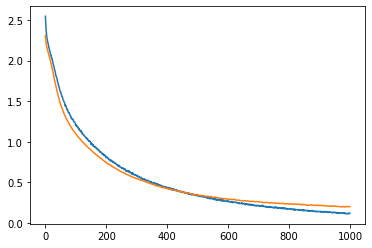

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

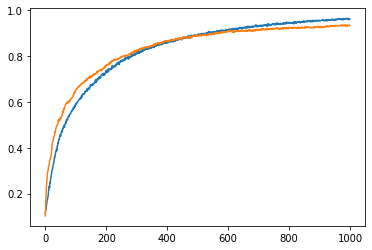

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
from tensorflow.keras import models
from sklearn.metrics import classification_report
model = models.load_model('app/saved_models/audio_classification.hdf5')

pred = model.predict(x_test).argmax(-1)
y_test = y_test.argmax(-1)
# pred

print(classification_report(y_true=y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        94
           1       0.96      0.94      0.95        47
           2       0.91      0.93      0.92       105
           3       0.92      0.84      0.88        86
           4       0.93      0.92      0.92        97
           5       0.95      0.97      0.96       120
           6       0.97      0.94      0.95        33
           7       0.96      0.95      0.95        96
           8       0.96      0.96      0.96       101
           9       0.84      0.88      0.86        95

    accuracy                           0.93       874
   macro avg       0.94      0.93      0.93       874
weighted avg       0.93      0.93      0.93       874



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = [cls for cls in labelencoder.classes_], 
                     columns = [cls for cls in labelencoder.classes_])

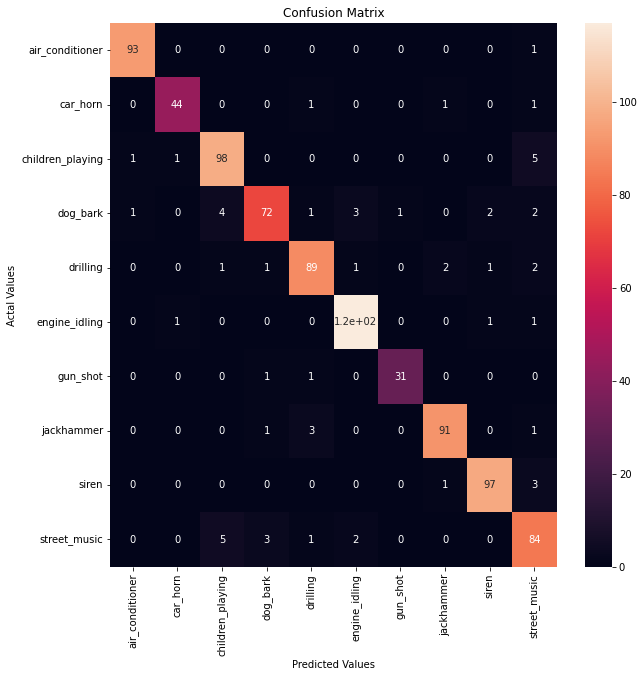

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import librosa
audiof = 'lightmachinegun2-7129.mp3'
y,sr=librosa.load(audiof)

mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
chroma_cq = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=40,bins_per_octave=40).T,axis=0)
chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=40,bins_per_octave=40).T,axis=0)

features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(1,40,5))
features.shape


C:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12000\3981388645.py:5: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


(1, 40, 5)

In [ ]:
feature = np.reshape(features ,(1,40,5,1))
feature.shape

(1, 40, 5, 1)

In [ ]:
model.predict(feature).argmax(-1)

array([3], dtype=int64)

In [ ]:
labelencoder.classes_

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype='<U16')